In [1]:
FN = '161103-run-plot'

Plot validation accuracy vs. noise level for different experiments

the results of the experiments are accumlated in:

In [2]:
FN1 = '160919-run-plot'

each experiment is run by `run.bash` which runs the same experiment with different training size (`down_sample=.2,.5,1`) and in each time it runs (`run_all.bash`) with 5 different seeds.
Each such run of `jacob-reed.py` includes a loop over different `noise_level`

In [3]:
%%bash -s "{FN1}"
echo $1
./run.bash --FN=data/$1
# ./run.bash --FN=data/$1 --model=simple --beta=0
# ./run.bash --FN=data/$1 --model=complex --beta=0 --pretrain=2
# ./run.bash --FN=data/$1 --model=reed_hard --beta=0.8
# ./run.bash --FN=data/$1 --model=reed_soft --beta=0.95

160919-run-plot
Writining all results to data/160919-run-plot...
you cant pretrain a baseline model
Writining all results to data/160919-run-plot...
you cant pretrain a baseline model
Writining all results to data/160919-run-plot...
you cant pretrain a baseline model
MNIST training data set label distribution [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
test distribution [ 980 1135 1032 1010  982  892  958 1028  974 1009]
stratified train [1185 1348 1192 1226 1168 1084 1184 1253 1170 1190]
X_train shape: (12000, 784)
12000 train samples
10000 test samples
Experiment BM_45-7904213568_2s
Writining all results to data/160919-run-plot...
you cant pretrain a baseline model
MNIST training data set label distribution [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
test distribution [ 980 1135 1032 1010  982  892  958 1028  974 1009]
stratified train [1185 1348 1192 1226 1168 1084 1184 1253 1170 1190]
X_train shape: (12000, 784)
12000 train samples
10000 test samples
Experiment BM_4

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
jacob-reed.py:334: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, kernel_regularizer=None, input_shape=(784,))`
  W_regularizer=regularizer))
jacob-reed.py:334: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, kernel_regularizer=None, input_shape=(784,))`
  W_regularizer=regularizer))
jacob-reed.py:334: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, kernel_regularizer=None, input_shape=(784,))`
  W_regularizer=regularizer))
jacob-reed.py:334: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, kernel_regularizer=None, input_shape=(784,))`
  W_regularizer=regularizer))
jacob-reed.py:334: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, kernel_regularizer=None, input_shape=[])`
  W_regularizer=regularizer))
jacob-reed.py:334: UserWarning: Update your `Dens

In [4]:
import fasteners
import time
import os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import pickle
import warnings ; warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'

In [6]:
with fasteners.InterProcessLock('/tmp/%s.lock_file'%FN1):
    with open('data/%s.results.pkl'%FN1,'rb') as fp:
        results = pickle.load(fp)

In [7]:
experiments = set([k[0] for k in results.keys()]) # find all unique experiments from experiment,noise keys
experiments = sorted(experiments)

In [8]:
print experiments

['BM_43-7904213568_10s', 'BM_44-7904213568_2s', 'BM_45-7904213568_10s']


The different models for which we have results. Composed from the following:
* B baseline, S simple, C complex, R reed soft, r reed hard
* M for MLP, C for CNN
* If the model is not baseline then beta is less than 1 and its value **after the decimal dot** appears (e.g. beta=0.85 will show as 85.) Note that if beta happens to be zero then nothing will appear
* Pre-training using labels generated by: p=baseline, q=simple model. r=use simple weights as a start point for the bias of the channel matrix instead of rebuilding it from the labels predicted by the simple model
* If model is complex then the value (usually 0) used to initialize channel matrix weights (unless it was 0.1)

In [9]:
print "Models:",', '.join(set(x.split('-')[0] for x in experiments))

Models: BM_45, BM_44, BM_43


The noise used:

In [10]:
print "Noise:",', '.join(set(x.split('-')[1].split('_')[0] for x in experiments))

Noise: 7904213568


different seeds used

size of training data used. Multiply by 10 to get percentage, s at the end indicate that the number of labels in training set is stratified

In [11]:
print "Training size:",', '.join(set(x.split('-')[1].split('_')[2] for x in experiments))

Training size:

IndexError: list index out of range

Count how many experiments (by different seeds) we did for every model/train-size combinations

In [12]:
e2n = defaultdict(int)
for e in reversed(experiments):
    model_noise, seed, train_size = e.split('_')
    e2n['_'.join([model_noise, train_size])] += 1
# e2n

In [13]:
#http://people.duke.edu/~ccc14/pcfb/analysis.html
def bootstrap(data, num_samples, statistic, alpha):
    """Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic."""
    n = len(data)
    idx = np.random.randint(0, n, (num_samples, n))
    samples = data[idx]
    stat = np.sort(statistic(samples, 1))
    return (stat[int((alpha/2.0)*num_samples)],
            stat[int((1-alpha/2.0)*num_samples)])

convert model code to label we will use in the graph's legend

In [14]:
namelookup = {'CMp0':'Complex baseline-labels',
              'CMq0':'Complex', # simple-labels',
              'CCq0':'Complex CNN', # simple-labels',
              'CMr0':'Complex simple-weights',
              'BM':'Baseline','BC':'Baseline CNN',
              'SMp':'Simple','SMP':'Simple soft confusion',
              'SCp':'Simple CNN','SCP':'Simple CNN soft confusion',
              'rM8p':'Reed hard','RM95p':'Reed soft',
              'rC8p':'Reed hard','RC95p':'Reed soft',
              'rMp':'Reed hard beta=0','RMp':'Reed soft beta=0'}

the order in which the graphs will appear in the legend (and colors)

In [15]:
model_order = {'SMp':3, 'SCp':3, 'CMp0':0, 'CMq0':1, 'CCq0':1, 'CMr0':2,
               'rM8p':4, 'rC8p':4, 'rMp':5,
               'RM95p':6, 'RC95p':6, 'RMp':7,
               'BM':8,'BC':9, 'SMP':10}

In [16]:
def plot(idx, models=None, perm=None, down_samples=None,xlim=(0.3,0.5),ylim=(0.4,1),title='', stat=np.mean):
    """
    models - list of str
        take only experiments that starts with one of the str in models.
    down_samples - list of float or str
        take only results with specificed down sample
    title - if None then dont produce any title. If string then build a title which includes in it the given str
    """
    if down_samples is not None:
        if not isinstance(down_samples,list):
            down_samples = [down_samples]
        down_samples = [down_sample if isinstance(down_sample, basestring)
                        else '%g'%(down_sample*10)
                        for down_sample in down_samples]

    plt.subplot(idx)
    
    e2xy = defaultdict(lambda : defaultdict(list))
    for e in reversed(experiments):
        if down_samples is not None:
            for down_sample in down_samples:
                if e.endswith('_'+down_sample) or e.endswith('_'+down_sample+'s'):
                    break
            else:
                continue
        if models:
            for model in models:
                if e.startswith(model):
                    break
            else:
                continue
        else:
            model = e.split('-')[0]
        down_sample = e.split('_')[-1]
        if perm is not None:
            pperm = e.split('-')[1].split('_')[0]
            if pperm != perm:
                continue
        
        X = [k[1] for k in results.keys() if k[0] == e]
        Y = []
        for n in X:
            d = results[(e,n)][1]
            for k in ['baseline_acc', 'acc']:
                if k in d:
                    Y.append(d[k])
                    break
            else:
                raise Exception('validation accuracy not found')
        X, Y = zip(*sorted(zip(X,Y),key=lambda x: x[0]))
        
        for x,y in zip(X,Y):
            e2xy[(model,down_sample)][x] += [y]
            
        Y = np.array(Y)

    keys = sorted(e2xy.keys(),key=lambda md: (model_order[md[0].split('-')[0]], (' ' if len(md[1])-int(md[1].endswith('s'))==1 else '') + md[1]))

    # determine if all down_sample are stratified (True) or all not stratified (False) or mixed (Nones)
    all_stratified = None
    for model,down_sample in keys:
        if all_stratified is None:
            all_stratified = down_sample.endswith('s')
        elif all_stratified != down_sample.endswith('s'):
            all_stratified = None
            break

    for c, (model,down_sample) in enumerate(keys):
        xy = e2xy[(model,down_sample)]
        X = []
        Y = []
        Ys = []
        for x in sorted(xy.keys()):
            X.append(x)
            Y.append(stat(xy[x]))
            Ys.append(xy[x])
        error_bars = []
        for y,ys in zip(Y,Ys):
            ym, yp = bootstrap(np.array(ys), 10000, stat, 0.05)
            error_bars.append((y-ym,yp-y))
        X = np.array(X)
        
        colors = ['b','g','r','c','m','k']
        linestyles=['solid', 'dashed','dashdot','dotted']
        color = colors[c % len(colors)]
        linestyle = linestyles[(c//len(colors))%len(linestyles)]
        plt.errorbar(X + 0.001*np.random.random(len(X)),
                     Y, yerr=np.array(error_bars).T, ecolor=color, elinewidth=2, alpha=0.2,
                    fmt='none')
        # label of each graph is the model name in English and
        # if we have more than one downsample option then also add it to the label
        if model in namelookup:
            label = namelookup[model]
        else:
            label = namelookup[model.split('-')[0]] + ' ' + model.split('-')[1]
        if down_samples is None or len(down_samples) > 1:
            if all_stratified is None:
                label += ' '+(down_sample[:-1]+'0% stratified' if down_sample.endswith('s') else down_sample+'0%')
            else:
                label += ' '+(down_sample[:-1] if down_sample.endswith('s') else down_sample)+'0%'
        plt.plot(X,Y, color=color, linestyle=linestyle, label=label)
    plt.legend(loc='lower left')
    plt.ylabel('test accuracy', fontsize=18)
    plt.xlabel('noise fraction', fontsize=18);
    if title is not None:
        title = 'MNIST '+title
        if all_stratified:
            title += ' stratified'
        plt.title(title)
    # The range of X and Y is exactly like in other paper
    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)

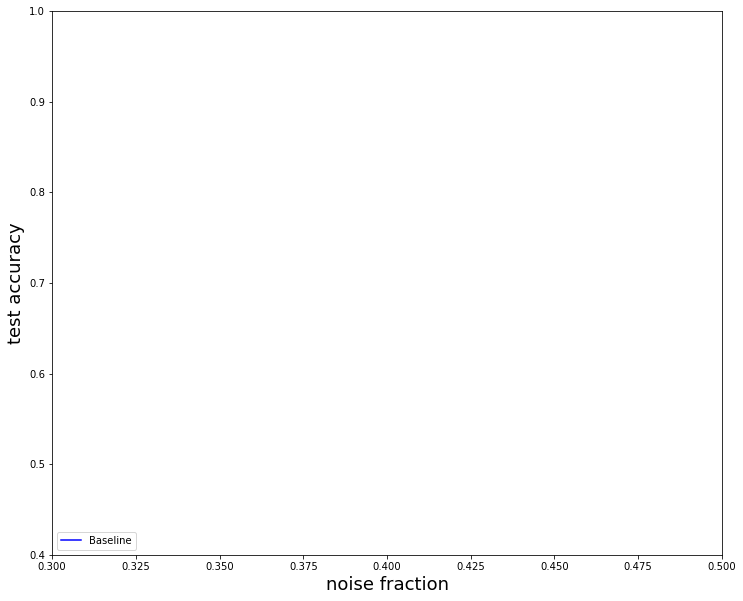

In [17]:
plt.figure(figsize=(12,10))
plot(111, down_samples=1, models=['BM','SMp','CMq0','rM8p','RM95p'], title=None, perm='7904213568') 

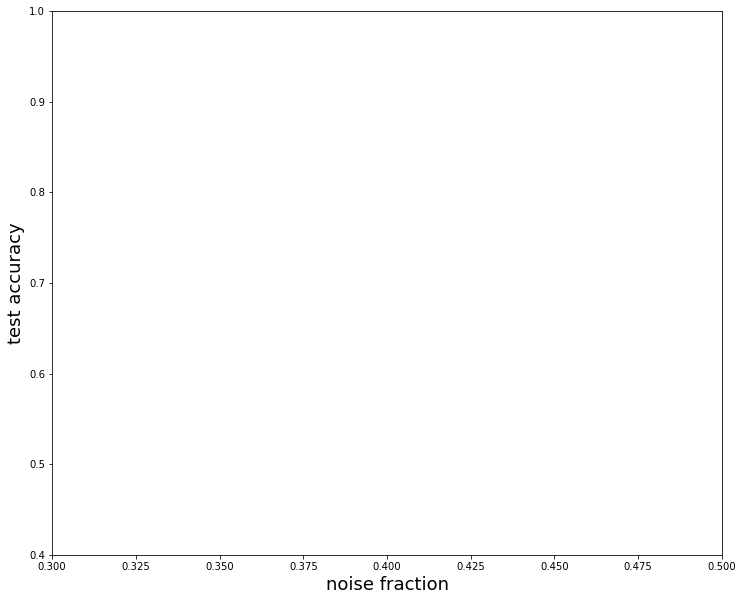

In [18]:
plt.figure(figsize=(12,10))
plot(111, down_samples=.5, models=['BM','SMp','CMq0','rM8p','RM95p'], title=None, perm='7904213568') 

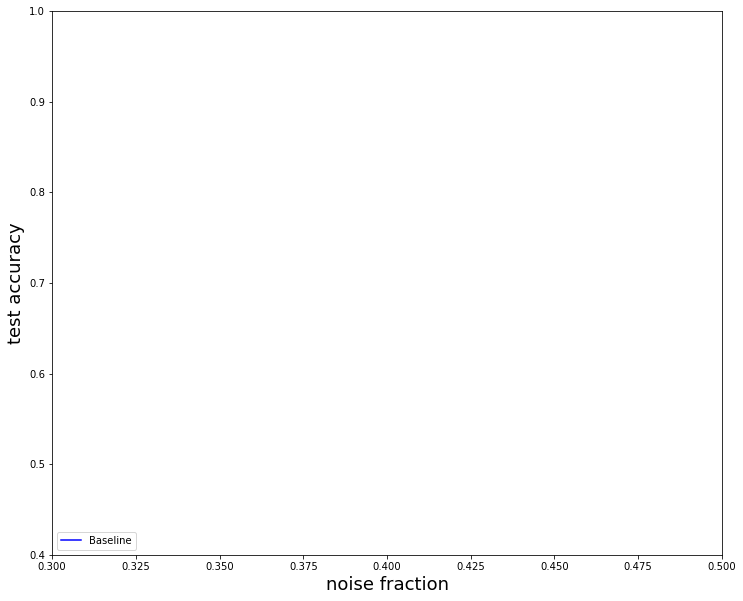

In [19]:
plt.figure(figsize=(12,10))
plot(111, down_samples=.2, models=['BM','SMp','CMq0','rM8p','RM95p'], title=None, perm='7904213568') 